[nltk_data] Downloading package omw-1.4 to /home/sergei/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sergei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sergei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sergei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


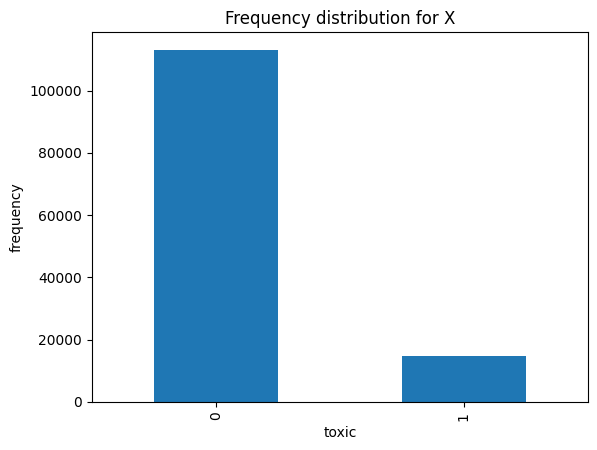

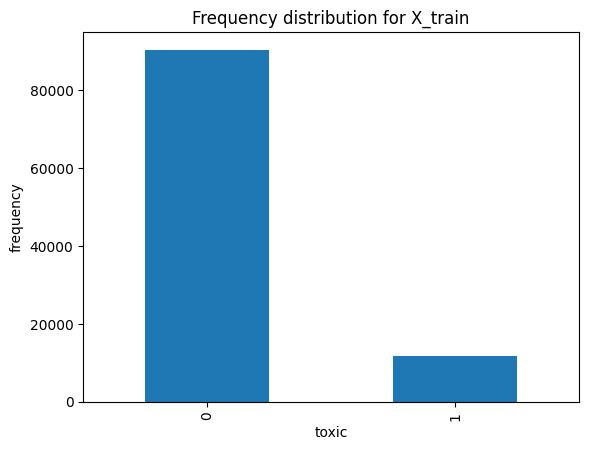

Validation F1 score without GridSearch = 0.7075751163774864


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   56.9s finished


CV F1 score without GridSearch =  0.7075751163774864
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=0.8;, score=0.691 total time=   8.0s
[CV 2/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=0.8;, score=0.694 total time=   7.4s
[CV 3/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=0.8;, score=0.679 total time=   7.3s
[CV 1/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=1.0;, score=0.684 total time=   7.9s
[CV 2/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=1.0;, score=0.695 total time=   8.1s
[CV 3/3] END clf__colsample_bytree=0.8, clf__gamma=0, clf__max_depth=5, clf__min_child_weight=1, clf__subsample=1.0;, score=0.678 total time

/tmp/ipykernel_14505/3741693395.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer['toxic'] = xgb_cv_pred


In [2]:
#  ----------------------------------------------------------------------------
#  ----------------------------------------------------------------------------
#  XGBoost classification
#  ----------------------------------------------------------------------------
#  ----------------------------------------------------------------------------

# Imports
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Classifier
from xgboost import XGBClassifier

# Load the data
comments_train = pd.read_csv('problem-set-3-2023-bbunny-master/coms_tr.csv')
comments_test = pd.read_csv('problem-set-3-2023-bbunny-master/coms_te.csv')

# Text preprocessing
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()


def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize text
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


comments_train['comment'] = comments_train['comment'].apply(preprocess_text)
comments_test['comment'] = comments_test['comment'].apply(preprocess_text)

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(comments_train['comment'],
                                                      comments_train['toxic'],
                                                      test_size=0.2,
                                                      random_state=1)

# Look at data
comments_train['toxic'].value_counts().plot(kind='bar', xlabel='toxic', ylabel='frequency')
plt.title('Frequency distribution for X')
plt.show()

y_train.value_counts().plot(kind='bar', xlabel='toxic', ylabel='frequency')
plt.title('Frequency distribution for X_train')
plt.show()

#  ----------------------------------------------------------------------------
#  XGB without GridSearch
#  ----------------------------------------------------------------------------

# Pipeline with basic pre-processing steps
xgb = Pipeline([
    ('vect', TfidfVectorizer()),  # to tf-idf representation.
    ('clf', XGBClassifier()),
])

# Fit and evaluate.
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_valid)

print("Validation F1 score without GridSearch =", f1_score(y_valid, xgb_pred, pos_label=1))

f1_cv_full = cross_val_score(xgb, comments_train.comment,
                             comments_train.toxic,
                             n_jobs=-1,
                             verbose=3,
                             scoring='f1',
                             cv=3)

print("CV F1 score without GridSearch = ", f1_score(y_valid, xgb_pred, pos_label=1))

#  ----------------------------------------------------------------------------
#  OPTIMIZATION: XGB GridSearch
#  ----------------------------------------------------------------------------

# Init parameters for GridSearch
grid_parameters = {
    'clf__min_child_weight': [1, 5],
    'clf__gamma': [0, 1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__max_depth': [5, 6, 7]
}

# Perform Grid Search CV
xgb_cv = GridSearchCV(xgb, grid_parameters, cv=3,
                      scoring='f1', verbose=3)

# Fit
xgb_cv.fit(X_train, y_train)

# Validation
xgb_cv_pred = xgb_cv.predict(X_valid)
print("Validation F1 score =", f1_score(y_valid, xgb_cv_pred, pos_label=1))

# Estimator and CV score
print("Best estimator =", xgb_cv.best_estimator_)
print("Best CV F1 score =", xgb_cv.best_score_)

#  ----------------------------------------------------------------------------
#  OUTPUT
#  ----------------------------------------------------------------------------

# Transform test data
xgb_cv_pred = xgb_cv.predict(comments_test.comment)
xgb_cv_pred = xgb_cv_pred.tolist()

# Create answers output
answer = comments_test[:]
answer['toxic'] = xgb_cv_pred

answer[['rev_id', 'toxic']].to_csv('xgb_submission.csv', index=False)


In [3]:
import pickle

with open('xgb.pkl', 'wb') as f:
    pickle.dump(xgb_cv, f)

